**# - AI - Convolutional Neural networks from Scratch, Fine Tuning and Hybrid CNN with CBAM and SENet**



In [2]:
# Import required packages from Pytorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

# fix random seed for reproducibility
import numpy as np
np.random.seed(7)

# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


## PART 1: **BUILD A CNN MODEL FROM SCRATCH WITH CBAM AND SENeT**


**Addition of an “Early Stopping” function to prevent overfitting if the loss of validation does not improve over a specified number of epochs (patience).**

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import time
import matplotlib.cm as cm

# SENet Module
class SENet(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SENet, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y

# CBAM Module
class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(CBAMBlock, self).__init__()
        self.channel_attention = SENet(channels, reduction)
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Channel Attention
        x = self.channel_attention(x)
        # Spatial Attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_out = torch.cat([avg_out, max_out], dim=1)
        x = x * self.spatial_attention(spatial_out)
        return x

# Baseline CNN
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Hybrid CNN with CBAM and SENet
class HybridCNN(nn.Module):
    def __init__(self):
        super(HybridCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.se = SENet(128)
        self.cbam = CBAMBlock(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        # Define standard forward method
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.se(x)
        x = self.cbam(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def forward_with_maps(self, x):
        # Include spatial and channel maps for visualization
        spatial_maps = []
        channel_maps = []

        x = self.pool(F.relu(self.conv1(x)))
        spatial_maps.append(x.mean(dim=1, keepdim=True))
        channel_maps.append(x.mean(dim=(2, 3), keepdim=True))

        x = self.pool(F.relu(self.conv2(x)))
        spatial_maps.append(x.mean(dim=1, keepdim=True))
        channel_maps.append(x.mean(dim=(2, 3), keepdim=True))

        x = self.pool(F.relu(self.conv3(x)))
        spatial_maps.append(x.mean(dim=1, keepdim=True))
        channel_maps.append(x.mean(dim=(2, 3), keepdim=True))

        x = self.se(x)
        x = self.cbam(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x, spatial_maps, channel_maps

# Load CIFAR-10 data
def load_data(batch_size):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader

# Training and Evaluation
def train_model(model, trainloader, testloader, epochs, criterion, optimizer):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    since = time.time()
    for epoch in range(epochs):
        model.train()
        total_train_loss, total_val_loss, correct_train, correct_val = 0.0, 0.0, 0, 0

        # Training Loop
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels).sum().item()

        # Validation Loop
        model.eval()
        with torch.no_grad():
            for images, labels in testloader:
                outputs = model(images)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels).sum().item()

        accuracy_train = correct_train / len(trainloader.dataset)
        accuracy_val = correct_val / len(testloader.dataset)

        train_loss.append(total_train_loss / len(trainloader))
        val_loss.append(total_val_loss / len(testloader))
        train_acc.append(accuracy_train)
        val_acc.append(accuracy_val)

        print("Epoch: {}/{}  ".format(epoch + 1, epochs),
              "Training loss: {:.4f}  ".format(total_train_loss / len(trainloader)),
              "Validation loss: {:.4f}  ".format(total_val_loss / len(testloader)),
              "Train accuracy: {:.4f}  ".format(accuracy_train),
              "Validation accuracy: {:.4f}  ".format(accuracy_val))

    print("Training time: {:.2f}s".format(time.time() - since))
    return train_loss, val_loss, train_acc, val_acc

# Visualization of Evaluation Curves
def plot_evaluation_curves(train_loss, val_loss, train_acc, val_acc, model_name):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 6))

    # Plot Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss Curves')
    plt.legend()

    # Plot Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy Curves')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main Workflow
batch_size, epochs, learning_rate = 16, 50, 0.001
trainloader, testloader = load_data(batch_size)

# Initialize models
baseline_model = BaselineCNN()
se_model = HybridCNN()  # Assuming HybridCNN includes SENet
cbam_model = HybridCNN()  # Assuming HybridCNN includes CBAM
cnn_senet_cbam_model = HybridCNN()  # Assuming HybridCNN includes both SENet and CBAM

# Initialize optimizers
criterion = nn.CrossEntropyLoss()
baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=learning_rate)
se_optimizer = torch.optim.Adam(se_model.parameters(), lr=learning_rate)
cbam_optimizer = torch.optim.Adam(cbam_model.parameters(), lr=learning_rate)
cnn_senet_cbam_optimizer = torch.optim.Adam(cnn_senet_cbam_model.parameters(), lr=learning_rate)

# Train and Evaluate
print("Training Baseline CNN")
baseline_train_loss, baseline_val_loss, baseline_train_acc, baseline_val_acc = train_model(
    baseline_model, trainloader, testloader, epochs, criterion, baseline_optimizer)
plot_evaluation_curves(baseline_train_loss, baseline_val_loss, baseline_train_acc, baseline_val_acc, "Baseline CNN")

print("Training CNN with SENet")
se_train_loss, se_val_loss, se_train_acc, se_val_acc = train_model(
    se_model, trainloader, testloader, epochs, criterion, se_optimizer)
plot_evaluation_curves(se_train_loss, se_val_loss, se_train_acc, se_val_acc, "CNN with SENet")

print("Training CNN with CBAM")
cbam_train_loss, cbam_val_loss, cbam_train_acc, cbam_val_acc = train_model(
    cbam_model, trainloader, testloader, epochs, criterion, cbam_optimizer)
plot_evaluation_curves(cbam_train_loss, cbam_val_loss, cbam_train_acc, cbam_val_acc, "CNN with CBAM")

print("Training CNN with SENet + CBAM")
cnn_senet_cbam_train_loss, cnn_senet_cbam_val_loss, cnn_senet_cbam_train_acc, cnn_senet_cbam_val_acc = train_model(
    cnn_senet_cbam_model, trainloader, testloader, epochs, criterion, cnn_senet_cbam_optimizer)
plot_evaluation_curves(cnn_senet_cbam_train_loss, cnn_senet_cbam_val_loss, cnn_senet_cbam_train_acc, cnn_senet_cbam_val_acc, "CNN with SENet + CBAM")


Training Baseline CNN
Epoch: 1/50   Training loss: 1.2841   Validation loss: 1.0113   Train accuracy: 0.5342   Validation accuracy: 0.6364  
Epoch: 2/50   Training loss: 0.8777   Validation loss: 0.8204   Train accuracy: 0.6917   Validation accuracy: 0.7140  
Epoch: 3/50   Training loss: 0.7396   Validation loss: 0.7716   Train accuracy: 0.7407   Validation accuracy: 0.7339  
Epoch: 4/50   Training loss: 0.6527   Validation loss: 0.6987   Train accuracy: 0.7723   Validation accuracy: 0.7572  
Epoch: 5/50   Training loss: 0.5920   Validation loss: 0.7460   Train accuracy: 0.7928   Validation accuracy: 0.7443  
Epoch: 6/50   Training loss: 0.5371   Validation loss: 0.7262   Train accuracy: 0.8120   Validation accuracy: 0.7630  
Epoch: 7/50   Training loss: 0.4916   Validation loss: 0.7221   Train accuracy: 0.8278   Validation accuracy: 0.7632  
Epoch: 8/50   Training loss: 0.4546   Validation loss: 0.7425   Train accuracy: 0.8406   Validation accuracy: 0.7707  
Epoch: 9/50   Training los

KeyboardInterrupt: 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Visualization of Attention Maps
def visualize_attention_maps_per_model(models, input_image):
    for model_name, model in models.items():
        print(f"Visualizing attention maps for {model_name}")

        # Forward pass to get outputs
        model.eval()
        with torch.no_grad():
            if isinstance(model, BaselineCNN):
                output = model(input_image)  # BaselineCNN does not have spatial and channel maps
                spatial_maps, channel_maps = None, None
            elif hasattr(model, 'forward_with_maps'):
                output, spatial_maps, channel_maps = model.forward_with_maps(input_image)
            else:
                output = model(input_image)
                spatial_maps, channel_maps = None, None

        if spatial_maps is None or channel_maps is None:
            print(f"{model_name} does not produce spatial or channel attention maps.")
            continue

        num_layers = len(spatial_maps)
        batch_idx = 0  # Visualize the first image in the batch

        # Convert the original image for display (CHW -> HWC)
        original_image = input_image[batch_idx].detach().cpu().numpy()
        if original_image.ndim == 3:
            original_image = original_image.transpose(1, 2, 0)
        original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())

        fig, axes = plt.subplots(2, num_layers + 1, figsize=((num_layers + 1) * 3, 6))

        # Display Original Image
        axes[0, 0].imshow(original_image)
        axes[0, 0].set_title("Original Image", fontsize=10)
        axes[0, 0].axis('off')
        axes[1, 0].axis('off')

        # Display Spatial and Channel Maps if available
        for i in range(num_layers):
            spatial_map = spatial_maps[i][batch_idx, 0].detach().cpu().numpy()
            axes[0, i + 1].imshow(spatial_map, cmap='viridis')
            axes[0, i + 1].set_title(f"Spatial Map\nLayer {i + 1}", fontsize=10)
            axes[0, i + 1].axis('off')

            channel_map = channel_maps[i][batch_idx].detach().cpu().numpy().flatten()
            axes[1, i + 1].bar(range(len(channel_map)), channel_map, color='purple')
            axes[1, i + 1].set_title(f"Channel Map\nLayer {i + 1}", fontsize=10)
            axes[1, i + 1].set_xticks([])
            axes[1, i + 1].set_yticks([])

        fig.suptitle(f"Attention Maps for {model_name}", fontsize=14)
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()

# Example Usage
# Assuming `input_image` is a batch of images from the test set and models are loaded
# Ensure the models output spatial and channel maps via forward_with_maps
def main():
    input_image, _ = next(iter(testloader))  # Get a batch of images from the testloader

    models = {
        "Baseline CNN": baseline_model,
        "CNN with SENet": se_model,
        "CNN with CBAM": cbam_model,
        "CNN with SENet + CBAM": cnn_senet_cbam_model
    }

    visualize_attention_maps_per_model(models, input_image)

# Call the visualization function
main()


NameError: name 'testloader' is not defined

## **PART 2**: ** FINE TUNING WITH CBAM AND SENeT: VGG, RESNeT, SQUEEZENeT**

### Implementation

Files already downloaded and verified
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 31.5MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 84.9MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s]


Training SqueezeNet
Epoch 1/2: Train Loss: 1.7828, Val Loss: 1.5392, Train Acc: 0.3226, Val Acc: 0.4518
Epoch 2/2: Train Loss: 1.2892, Val Loss: 1.1971, Train Acc: 0.5315, Val Acc: 0.5718
Training VGG
Epoch 1/2: Train Loss: 2.3106, Val Loss: 2.3062, Train Acc: 0.0998, Val Acc: 0.1000
Epoch 2/2: Train Loss: 2.3063, Val Loss: 2.3034, Train Acc: 0.1002, Val Acc: 0.1000
Training ResNet
Epoch 1/2: Train Loss: 0.8437, Val Loss: 0.5355, Train Acc: 0.7119, Val Acc: 0.8163
Epoch 2/2: Train Loss: 0.5195, Val Loss: 0.4438, Train Acc: 0.8242, Val Acc: 0.8453


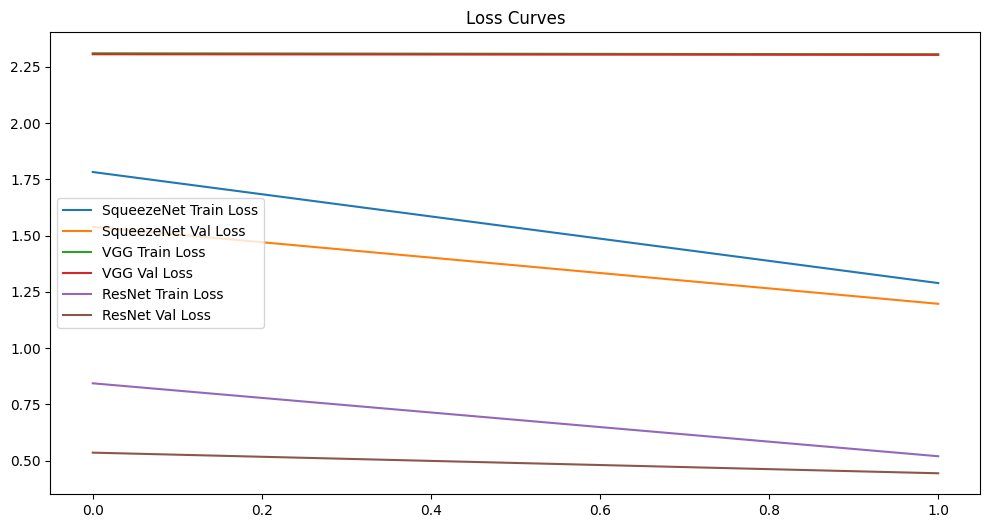

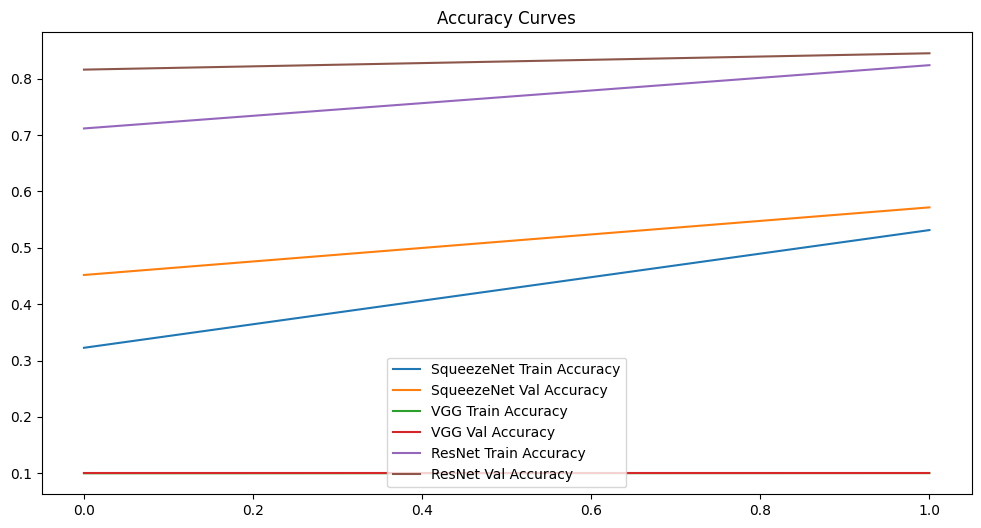

Visualizing Grid-CAM for SqueezeNet


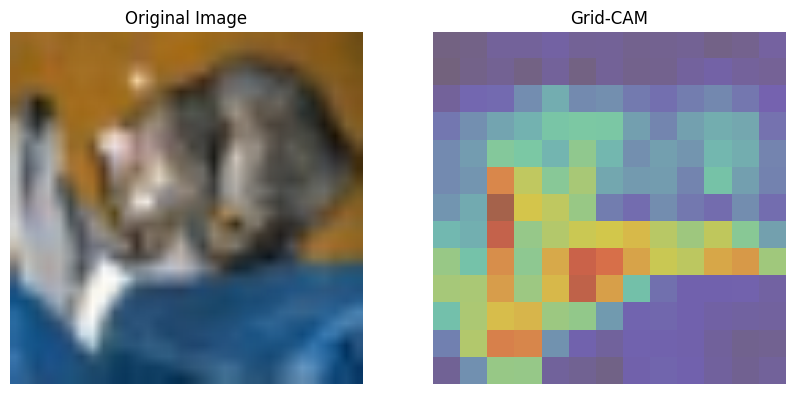

Visualizing Grid-CAM for VGG


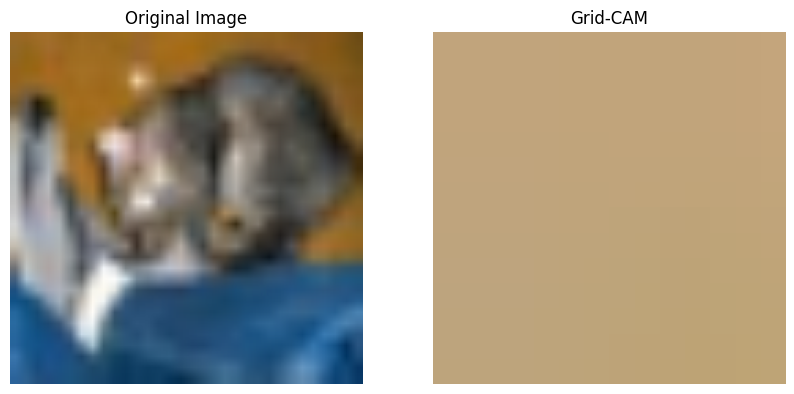

Visualizing Grid-CAM for ResNet


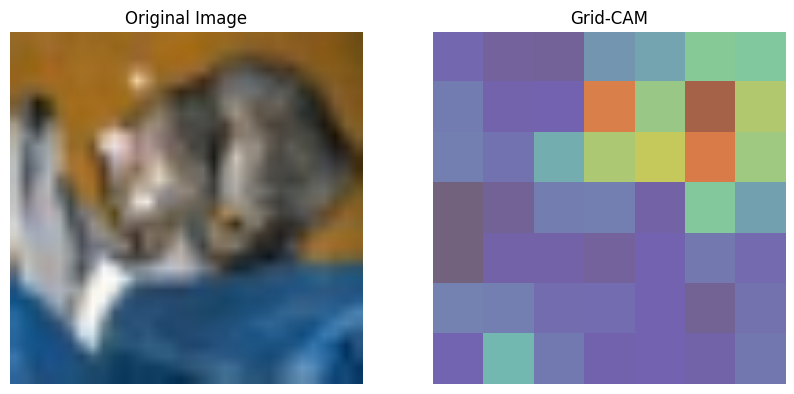

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import time
import matplotlib.cm as cm

# Configure device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# SENet Module
class SENet(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SENet, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y

# CBAM Module
class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(CBAMBlock, self).__init__()
        self.channel_attention = SENet(channels, reduction)
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Channel Attention
        x = self.channel_attention(x)
        # Spatial Attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_out = torch.cat([avg_out, max_out], dim=1)
        x = x * self.spatial_attention(spatial_out)
        return x

# Function to Integrate Attention Blocks

def integrate_attention_blocks(model, block_type, layers_to_modify, channels_list):
    for layer_name, channels in zip(layers_to_modify, channels_list):
        layer = dict(model.named_children())[layer_name]
        if block_type == 'SENet':
            attention_block = SENet(channels)
        elif block_type == 'CBAM':
            attention_block = CBAMBlock(channels)
        else:
            raise ValueError("Invalid block type")

        modified_layer = nn.Sequential(layer, attention_block)
        setattr(model, layer_name, modified_layer)
    return model

def visualize_grid_cam(model, image, target_layer_name, class_labels):
    model.eval()
    feature_maps = None
    target_layer = None

    # Extract target layer dynamically
    for name, module in model.named_modules():
        if name == target_layer_name:
            target_layer = module
            break

    if target_layer is None:
        raise ValueError(f"Target layer {target_layer_name} not found in the model")

    with torch.no_grad():
        hooks = []

        def hook_fn(module, input, output):
            nonlocal feature_maps
            feature_maps = output

        hooks.append(target_layer.register_forward_hook(hook_fn))
        model(image)  # Forward pass
        for hook in hooks:
            hook.remove()

        if feature_maps is None:
            raise ValueError("Feature maps not generated for the target layer")

        weights = torch.mean(feature_maps, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * feature_maps, dim=1).squeeze(0).cpu()  # Transfer to CPU
        cam = F.relu(cam)
        cam = cam / cam.max()

    # Display Original Image and CAM
    original_image = image.squeeze(0).cpu().permute(1, 2, 0).numpy()  # Transfer to CPU before converting to NumPy
    original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(original_image, alpha=0.6)
    plt.imshow(cam.numpy(), cmap='jet', alpha=0.4)
    plt.title("Grid-CAM")
    plt.axis('off')
    plt.show()

# Load CIFAR-10 data
def load_data(batch_size):
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader, testset

# Training and Evaluation
def train_model(model, trainloader, testloader, epochs, criterion, optimizer):
    model.to(device)  # Move model to the appropriate device
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    for epoch in range(epochs):
        model.train()
        total_train_loss, total_val_loss, correct_train, correct_val = 0.0, 0.0, 0, 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)  # Move data to the appropriate device
            labels = labels.long()  # Ensure labels are of type long
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels).sum().item()

        model.eval()
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)  # Move data to the appropriate device
                labels = labels.long()  # Ensure labels are of type long
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels).sum().item()

        accuracy_train = correct_train / len(trainloader.dataset)
        accuracy_val = correct_val / len(testloader.dataset)

        train_loss.append(total_train_loss / len(trainloader))
        val_loss.append(total_val_loss / len(testloader))
        train_acc.append(accuracy_train)
        val_acc.append(accuracy_val)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

    return train_loss, val_loss, train_acc, val_acc

# Main Workflow
batch_size, epochs, learning_rate = 16, 50, 0.001
trainloader, testloader, testset = load_data(batch_size)

# Pretrained Models
squeezenet = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.DEFAULT).to(device)
vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).to(device)
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)

# Modify Models
squeezenet.features = integrate_attention_blocks(squeezenet.features, block_type='SENet', layers_to_modify=['12'], channels_list=[512])
vgg.features = integrate_attention_blocks(vgg.features, block_type='CBAM', layers_to_modify=['28'], channels_list=[512])
resnet.layer4 = integrate_attention_blocks(resnet.layer4, block_type='SENet', layers_to_modify=['0'], channels_list=[512])

# Adjust classifier layers to match modified models
squeezenet.classifier[1] = nn.Conv2d(512, 10, kernel_size=1).to(device)
squeezenet.num_classes = 10

vgg.classifier[0] = nn.Linear(512 * 7 * 7, 4096).to(device)
vgg.classifier[6] = nn.Linear(4096, 10).to(device)

resnet.fc = nn.Linear(512, 10).to(device)

# Training
criterion = nn.CrossEntropyLoss()
models_to_train = {'SqueezeNet': squeezenet, 'VGG': vgg, 'ResNet': resnet}
results = {}

for name, model in models_to_train.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(f"Training {name}")
    results[name] = train_model(model, trainloader, testloader, epochs, criterion, optimizer)

# Plot Evaluation
plt.figure(figsize=(8, 4))
for name, (train_loss, val_loss, train_acc, val_acc) in results.items():
    plt.plot(train_loss, label=f'{name} Train Loss')
    plt.plot(val_loss, label=f'{name} Val Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
for name, (train_loss, val_loss, train_acc, val_acc) in results.items():
    plt.plot(train_acc, label=f'{name} Train Accuracy')
    plt.plot(val_acc, label=f'{name} Val Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.show()

# Grid-CAM Visualization
sample_image, label = testset[0]
sample_image = sample_image.unsqueeze(0).to(device)

for name, model in models_to_train.items():
    target_layer_name = 'features.12' if name == 'SqueezeNet' else 'features.28' if name == 'VGG' else 'layer4.0'
    print(f"Visualizing Grid-CAM for {name}")
    visualize_grid_cam(model, sample_image, target_layer_name, testset.classes)


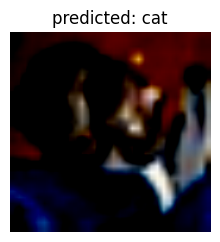

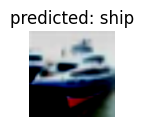

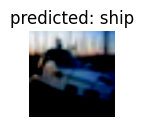

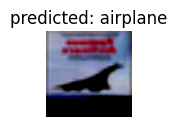

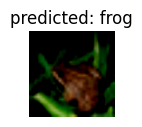

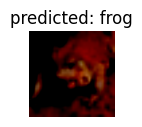

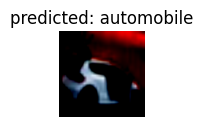

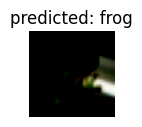

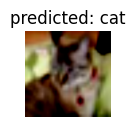

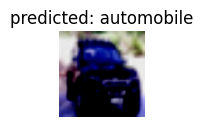

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Define your DataLoader objects for training and validation
dataloaders = {
    'train': trainloader,  # Replace with your actual train DataLoader
    'val': testloader  # Replace with your actual validation DataLoader
}

# Define the class names for CIFAR-10
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Define the imshow function (if not already defined)
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)  # Ensure the data is in the range [0, 1] for display
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Visualize model predictions
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 6))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(2, num_images // 2, images_so_far)  # Arrange images in 2 rows
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
    model.train(mode=was_training)

# Call the visualization function
visualize_model(model)

plt.ioff()
plt.show()


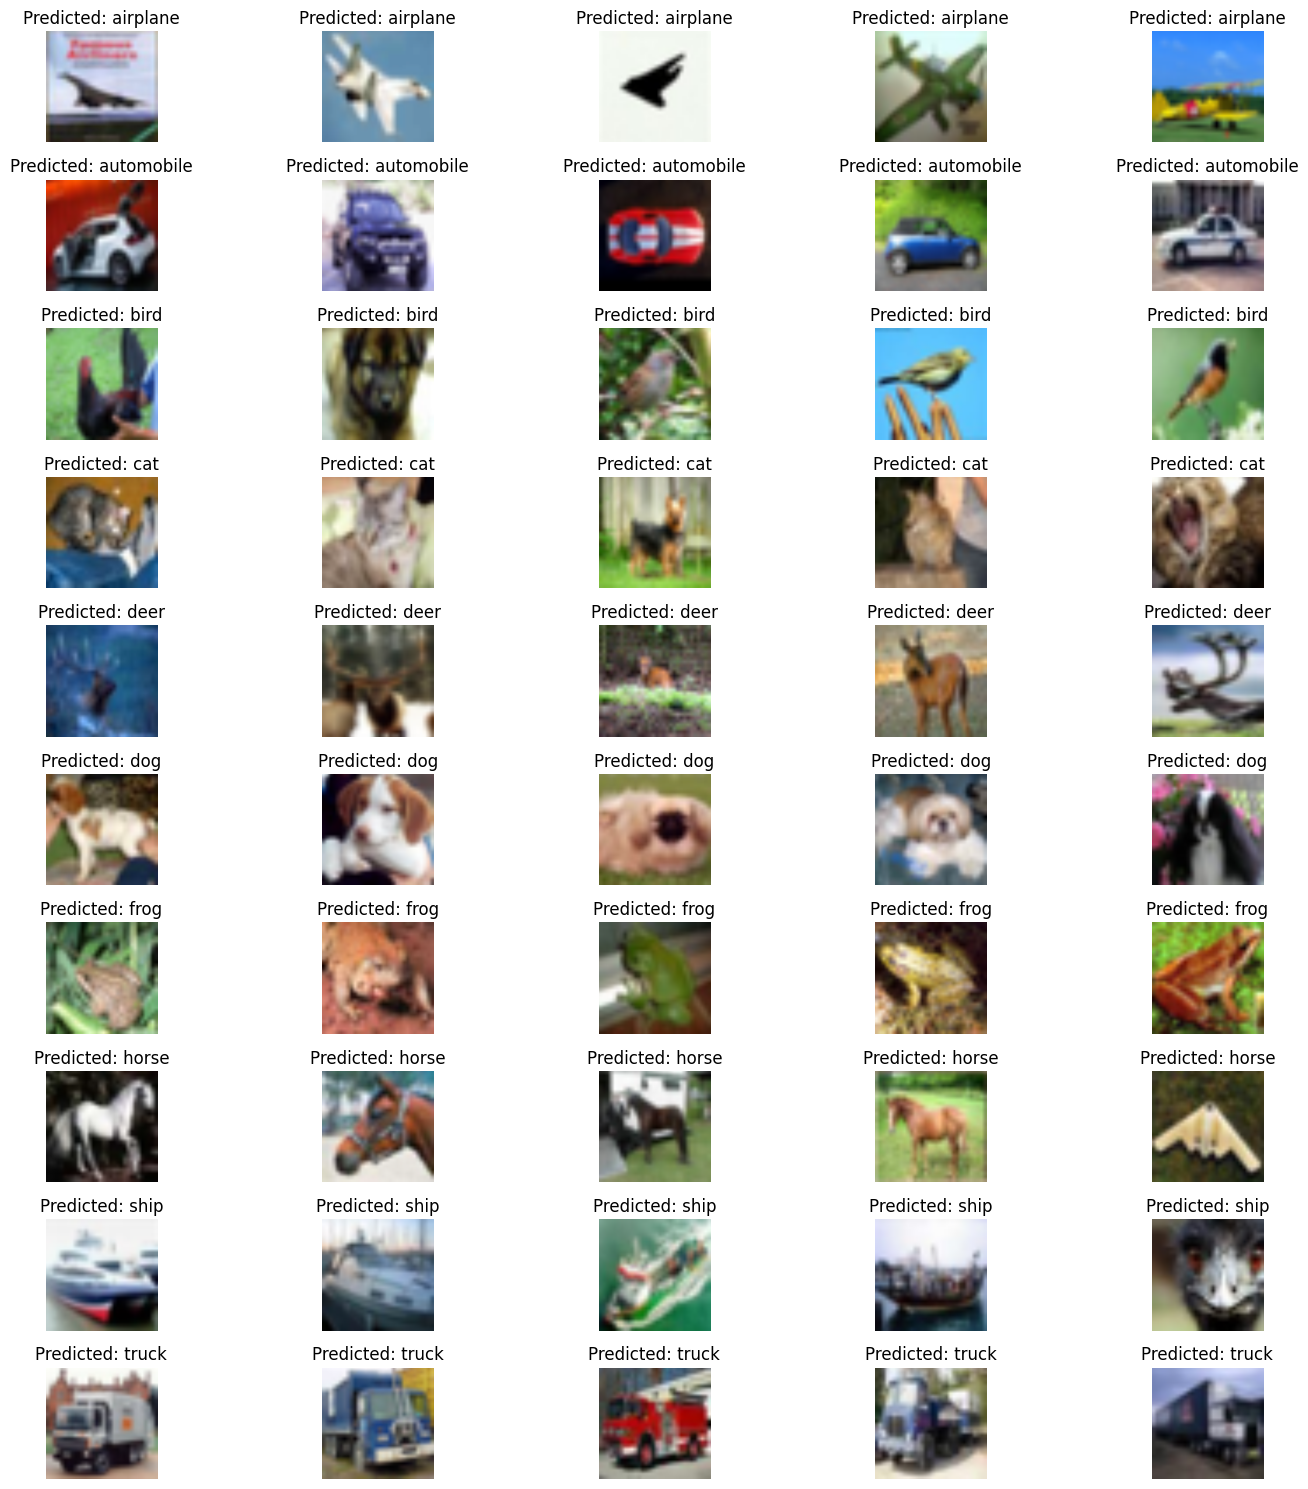

Prediction Summary:
airplane: 10
automobile: 6
bird: 7
cat: 13
deer: 8
dog: 9
frog: 17
horse: 13
ship: 17
truck: 12


In [ ]:
def print_prediction_summary(preds, class_names):
    prediction_counts = {class_name: 0 for class_name in class_names}
    for pred in preds:
        prediction_counts[class_names[pred]] += 1
    print("Prediction Summary:")
    for class_name, count in prediction_counts.items():
        print(f"{class_name}: {count}")

# Visualize model predictions with additional debug information
def visualize_model_grid_debug(model, num_classes=10, samples_per_class=5):
    was_training = model.training
    model.eval()
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(15, 15))

    counters = [0] * num_classes
    all_preds = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())

            for j in range(inputs.size()[0]):
                class_idx = preds[j].item()

                if counters[class_idx] < samples_per_class:
                    ax = axes[class_idx, counters[class_idx]]
                    ax.axis('off')

                    img = inputs.cpu().data[j].numpy().transpose(1, 2, 0)
                    img = (img - img.min()) / (img.max() - img.min())  # Normalize
                    ax.imshow(img)
                    ax.set_title(f'Predicted: {class_names[class_idx]}')

                    counters[class_idx] += 1

                if sum(counters) >= num_classes * samples_per_class:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    print_prediction_summary(all_preds, class_names)
                    return

    model.train(mode=was_training)
    plt.tight_layout()
    plt.show()
    print_prediction_summary(all_preds, class_names)

# Call the visualization function with debugging
visualize_model_grid_debug(model)

plt.ioff()
plt.show()


Files already downloaded and verified


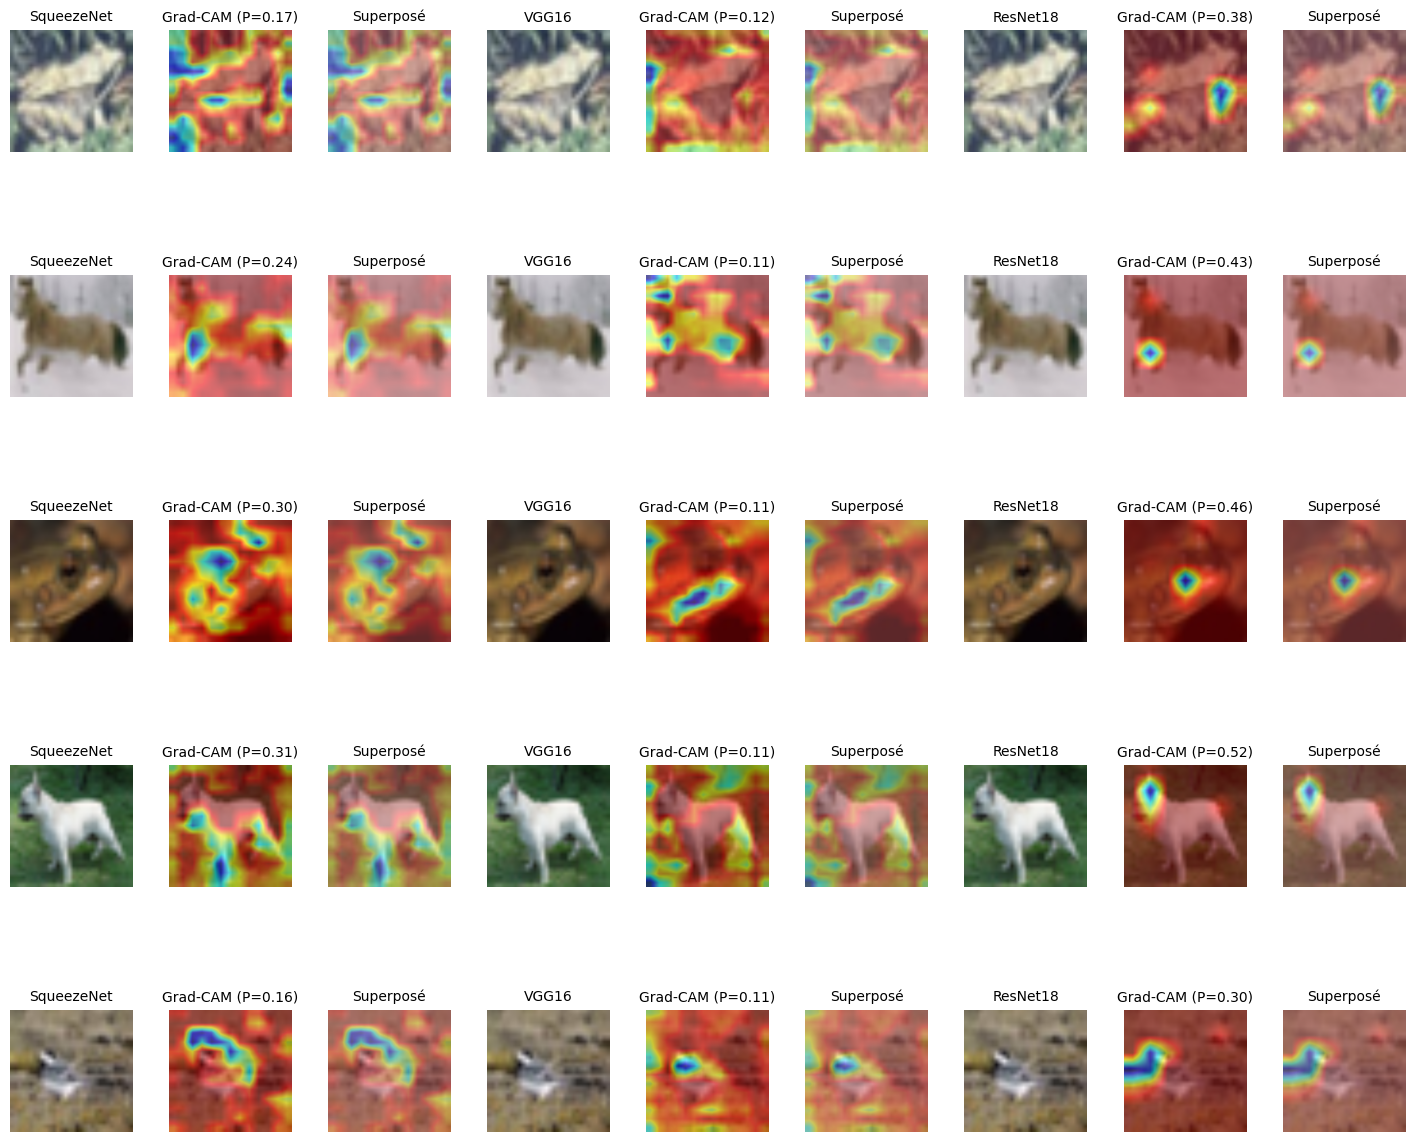

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms, datasets
from torch.nn import functional as F
from torch import nn
import cv2

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preparing transformations for CIFAR-10
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 dataset
cifar10 = datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)
dataloader = torch.utils.data.DataLoader(cifar10, batch_size=5, shuffle=True)
images, labels = next(iter(dataloader))

# CIFAR-10 class name definition
class_names = cifar10.classes

# Initialize models on the right device
squeezenet = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.DEFAULT).to(device)
vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).to(device)
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)

# Modifying models with attention blocks
squeezenet.features = integrate_attention_blocks(squeezenet.features, block_type='SENet', layers_to_modify=['12'], channels_list=[512])
vgg.features = integrate_attention_blocks(vgg.features, block_type='CBAM', layers_to_modify=['28'], channels_list=[512])
resnet.layer4 = integrate_attention_blocks(resnet.layer4, block_type='SENet', layers_to_modify=['0'], channels_list=[512])

# Adapt last layer for CIFAR-10
squeezenet.classifier[1] = nn.Conv2d(512, 10, kernel_size=1).to(device)
squeezenet.num_classes = 10
vgg.classifier[6] = nn.Linear(4096, 10).to(device)
resnet.fc = nn.Linear(resnet.fc.in_features, 10).to(device)

# Associating models and target layers
models_dict = {
    "SqueezeNet": (squeezenet, squeezenet.features[12].to(device)),
    "VGG16": (vgg, vgg.features[28].to(device)),
    "ResNet18": (resnet, resnet.layer4[0].to(device))
}

# Function to generate Grad-CAM
def generate_gradcam(model, img_tensor, target_layer):
    def hook_fn(module, input, output):
        model_output.append(output)

    model_output = []
    handle = target_layer.register_forward_hook(hook_fn)
    output = model(img_tensor.to(device))  # Make sure the input is on the right device
    handle.remove()

    pred_class = output.argmax(dim=1).item()
    pred_score = F.softmax(output, dim=1)[0][pred_class].item()

    grad_output = torch.autograd.grad(output[:, pred_class], model_output[0])[0]
    weights = grad_output.mean(dim=(2, 3), keepdim=True)

    gradcam = torch.sum(weights * model_output[0], dim=1).squeeze()
    gradcam = F.relu(gradcam)

    # Verification and standardization
    if gradcam.max() > 0:
        gradcam = gradcam / gradcam.max()
    else:
        print("[WARNING] Grad-CAM vide !")

    return gradcam.cpu(), pred_class, pred_score  # Make sure the output is on the CPU

# Visualize Grad-CAM
def visualize_gradcam_on_image(img_tensor, model, target_layer):
    gradcam, pred_class, pred_score = generate_gradcam(model, img_tensor, target_layer)

    # Size verification
    gradcam_resized = cv2.resize(gradcam.detach().numpy(), (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * gradcam_resized), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    img = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)

    cam_img = heatmap + np.float32(img)
    cam_img = cam_img / np.max(cam_img)

    return cam_img, pred_class, pred_score

# Image display with Grad-CAM
def display_gradcam_for_models(images, models_dict, class_names):
    num_images = len(images)
    num_models = len(models_dict)

    fig, axes = plt.subplots(num_images, num_models * 3, figsize=(num_models * 6, num_images * 3))

    for img_idx, img_tensor in enumerate(images):
        img = img_tensor.permute(1, 2, 0).cpu().numpy()
        img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)

        for model_idx, (model_name, (model, target_layer)) in enumerate(models_dict.items()):
            model.eval()
            cam_img, pred_class, pred_score = visualize_gradcam_on_image(img_tensor.unsqueeze(0).to(device), model, target_layer)

            col_idx = model_idx * 3

            # Display original image
            axes[img_idx, col_idx].imshow(img)
            axes[img_idx, col_idx].axis('off')
            axes[img_idx, col_idx].set_title(f"{model_name}", fontsize=10)

            # Grad-CAM card display
            axes[img_idx, col_idx + 1].imshow(cam_img)
            axes[img_idx, col_idx + 1].axis('off')
            axes[img_idx, col_idx + 1].set_title(f"Grad-CAM (P={pred_score:.2f})", fontsize=10)

            # Grad-CAM overlay on image
            axes[img_idx, col_idx + 2].imshow(img, alpha=0.5)
            axes[img_idx, col_idx + 2].imshow(cam_img, alpha=0.7)
            axes[img_idx, col_idx + 2].axis('off')
            axes[img_idx, col_idx + 2].set_title("overlay", fontsize=10)

    plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Adjusting margins
    plt.show()

# View Grad-CAM for all models
display_gradcam_for_models(images, models_dict, class_names)


Files already downloaded and verified


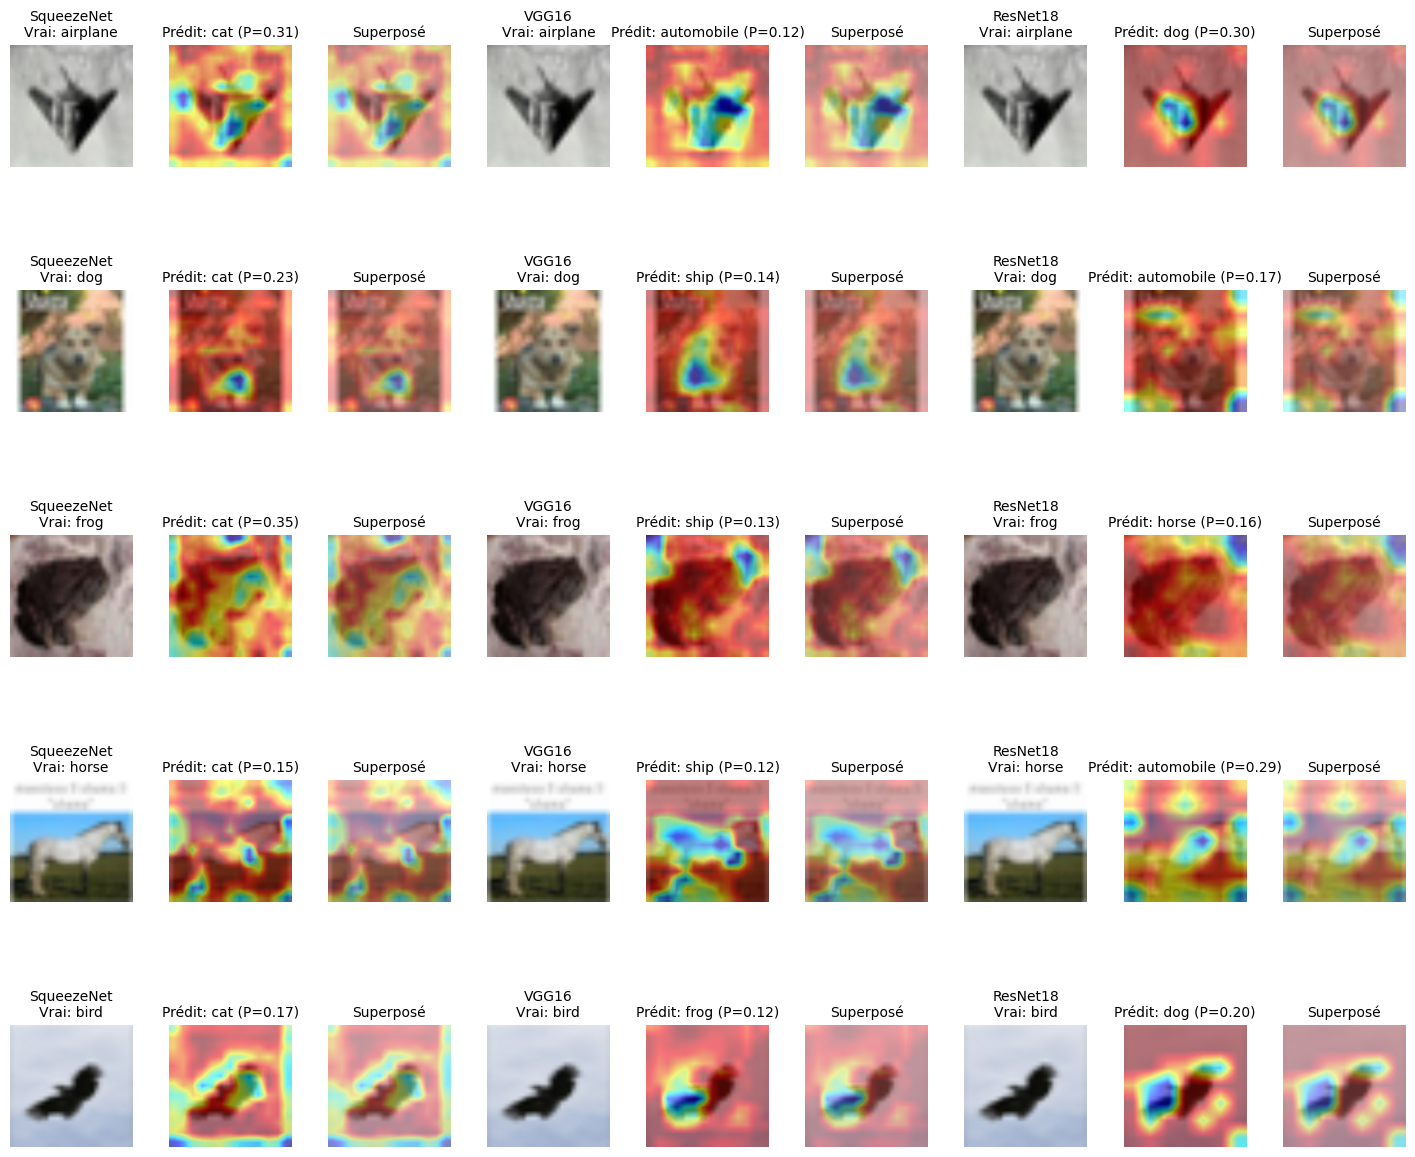

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms, datasets
from torch.nn import functional as F
from torch import nn
import cv2

# Check the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare transformations for CIFAR-10
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the CIFAR-10 dataset
cifar10 = datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)
dataloader = torch.utils.data.DataLoader(cifar10, batch_size=5, shuffle=True)
images, labels = next(iter(dataloader))

# Define CIFAR-10 class names
class_names = cifar10.classes

# Initialize models on the correct device
squeezenet = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.DEFAULT).to(device)
vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).to(device)
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)

# Modify models with attention blocks
squeezenet.features = integrate_attention_blocks(squeezenet.features, block_type='SENet', layers_to_modify=['12'], channels_list=[512])
vgg.features = integrate_attention_blocks(vgg.features, block_type='CBAM', layers_to_modify=['28'], channels_list=[512])
resnet.layer4 = integrate_attention_blocks(resnet.layer4, block_type='SENet', layers_to_modify=['0'], channels_list=[512])

# Adapt the final layer for CIFAR-10
squeezenet.classifier[1] = nn.Conv2d(512, 10, kernel_size=1).to(device)
squeezenet.num_classes = 10
vgg.classifier[6] = nn.Linear(4096, 10).to(device)
resnet.fc = nn.Linear(resnet.fc.in_features, 10).to(device)

# Associate models and target layers
models_dict = {
    "SqueezeNet": (squeezenet, squeezenet.features[12].to(device)),
    "VGG16": (vgg, vgg.features[28].to(device)),
    "ResNet18": (resnet, resnet.layer4[0].to(device))
}

# Function to generate Grad-CAM
def generate_gradcam(model, img_tensor, target_layer):
    def hook_fn(module, input, output):
        model_output.append(output)

    model_output = []
    handle = target_layer.register_forward_hook(hook_fn)
    output = model(img_tensor.to(device))  # Ensure the input is on the correct device
    handle.remove()

    pred_class = output.argmax(dim=1).item()
    pred_score = F.softmax(output, dim=1)[0][pred_class].item()

    grad_output = torch.autograd.grad(output[:, pred_class], model_output[0])[0]
    weights = grad_output.mean(dim=(2, 3), keepdim=True)

    gradcam = torch.sum(weights * model_output[0], dim=1).squeeze()
    gradcam = F.relu(gradcam)

    # Check and normalize
    if gradcam.max() > 0:
        gradcam = gradcam / gradcam.max()
    else:
        print("[WARNING] Empty Grad-CAM!")

    return gradcam.cpu(), pred_class, pred_score  # Ensure the output is on the CPU

# Visualize Grad-CAM
def visualize_gradcam_on_image(img_tensor, model, target_layer):
    gradcam, pred_class, pred_score = generate_gradcam(model, img_tensor, target_layer)

    # Check the size
    gradcam_resized = cv2.resize(gradcam.detach().numpy(), (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * gradcam_resized), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    img = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)

    cam_img = heatmap + np.float32(img)
    cam_img = cam_img / np.max(cam_img)

    return cam_img, pred_class, pred_score

# Display images with Grad-CAM and predictions
def display_gradcam_for_models(images, models_dict, class_names):
    num_images = len(images)
    num_models = len(models_dict)

    fig, axes = plt.subplots(num_images, num_models * 3, figsize=(num_models * 6, num_images * 3))

    for img_idx, img_tensor in enumerate(images):
        img = img_tensor.permute(1, 2, 0).cpu().numpy()
        img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)

        for model_idx, (model_name, (model, target_layer)) in enumerate(models_dict.items()):
            model.eval()
            cam_img, pred_class, pred_score = visualize_gradcam_on_image(img_tensor.unsqueeze(0).to(device), model, target_layer)

            col_idx = model_idx * 3

            # Display the original image with the correct class
            axes[img_idx, col_idx].imshow(img)
            axes[img_idx, col_idx].axis('off')
            axes[img_idx, col_idx].set_title(f"{model_name}\nTrue: {class_names[labels[img_idx]]}", fontsize=10)

            # Display the Grad-CAM map with the predicted class
            axes[img_idx, col_idx + 1].imshow(cam_img)
            axes[img_idx, col_idx + 1].axis('off')
            axes[img_idx, col_idx + 1].set_title(f"Predicted: {class_names[pred_class]} (P={pred_score:.2f})", fontsize=10)

            # Overlay Grad-CAM on the image
            axes[img_idx, col_idx + 2].imshow(img, alpha=0.5)
            axes[img_idx, col_idx + 2].imshow(cam_img, alpha=0.7)
            axes[img_idx, col_idx + 2].axis('off')
            axes[img_idx, col_idx + 2].set_title("Overlay", fontsize=10)

    plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Adjust margins
    plt.show()

# Display Grad-CAM for all models with predictions
display_gradcam_for_models(images, models_dict, class_names)


100%|██████████| 170M/170M [00:14<00:00, 11.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 90.3MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 179MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]



Fine-tuning SqueezeNet...
Epoch [1/2], Loss: 1.6027
Epoch [2/2], Loss: 1.1983

Fine-tuning VGG16...
Epoch [1/2], Loss: 1.9523
Epoch [2/2], Loss: 1.6421

Fine-tuning ResNet18...
Epoch [1/2], Loss: 0.7019
Epoch [2/2], Loss: 0.4473

Evaluating SqueezeNet...
Accuracy: 0.6082
Precision: 0.6408
Recall: 0.6082
F1 Score: 0.6020


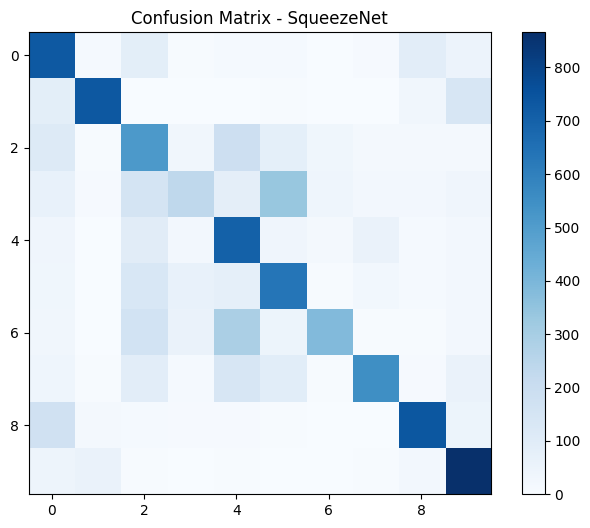


Evaluating VGG16...
Accuracy: 0.4533
Precision: 0.5055
Recall: 0.4533
F1 Score: 0.4420


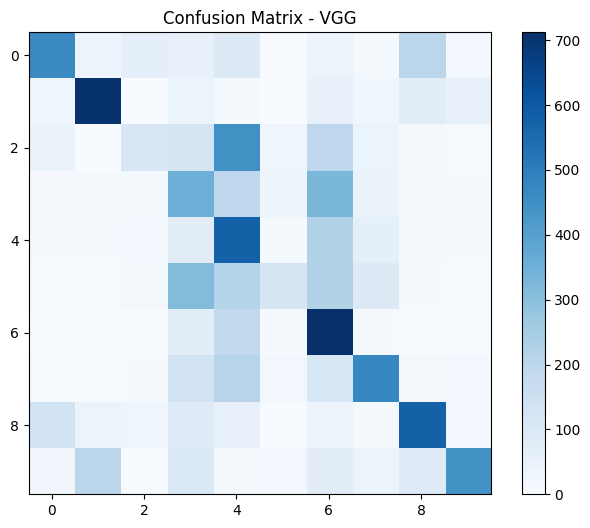


Evaluating ResNet18...
Accuracy: 0.8650
Precision: 0.8719
Recall: 0.8650
F1 Score: 0.8633


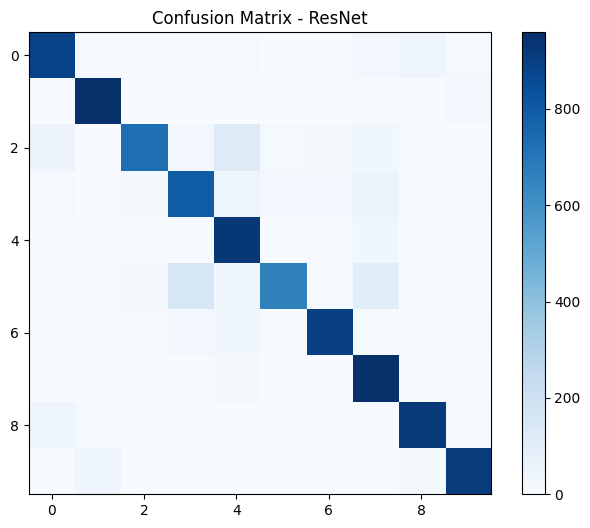

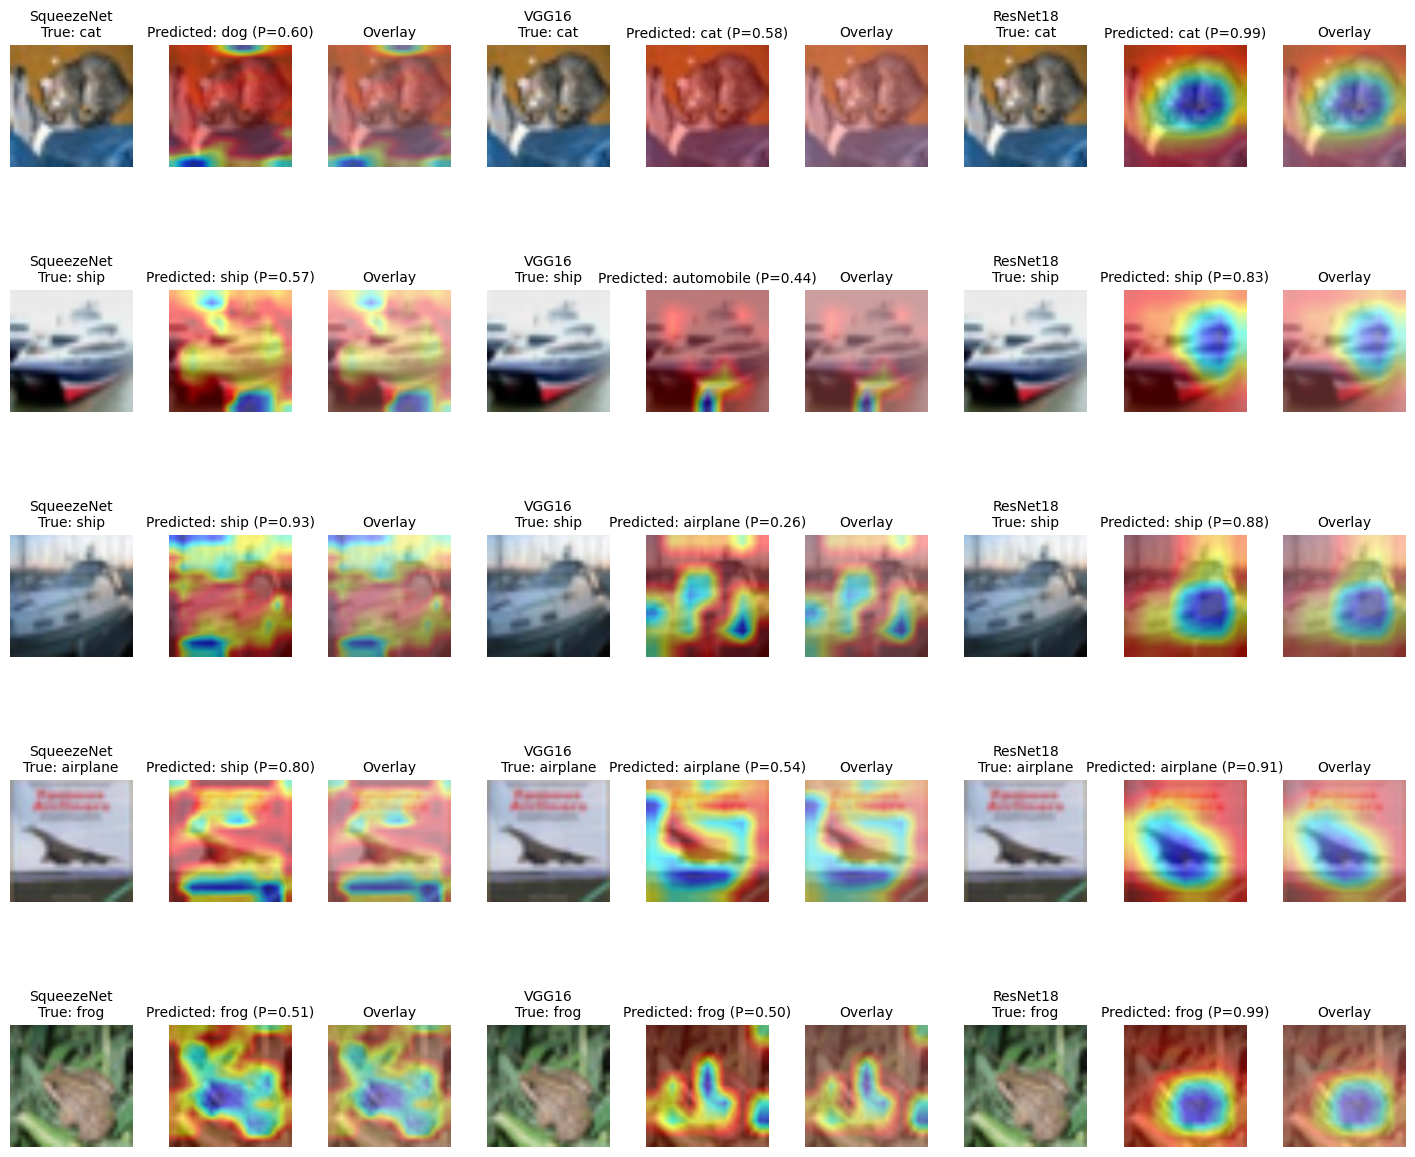

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms, datasets
from torch.nn import functional as F
from torch import nn
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Check the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare transformations for CIFAR-10 with data augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

class_names = trainset.classes

# Initialize models on the correct device
squeezenet = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.DEFAULT).to(device)
vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).to(device)
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)

# Modify models for CIFAR-10
squeezenet.classifier[1] = nn.Conv2d(512, 10, kernel_size=1).to(device)
vgg.classifier[6] = nn.Linear(4096, 10).to(device)
resnet.fc = nn.Linear(resnet.fc.in_features, 10).to(device)

models_dict = {
    "SqueezeNet": squeezenet,
    "VGG16": vgg,
    "ResNet18": resnet
}

# Training function
def train_model(model, trainloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(trainloader):.4f}")

# Train models
criterion = nn.CrossEntropyLoss()
epochs = 50

for name, model in models_dict.items():
    print(f"\nFine-tuning {name}...")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_model(model, trainloader, criterion, optimizer, epochs)

# Function to evaluate model performance
def evaluate_model(model, testloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    plt.figure(figsize=(6, 4))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model.__class__.__name__}")
    plt.colorbar()
    plt.show()

# Evaluate each model
for name, model in models_dict.items():
    print(f"\nEvaluating {name}...")
    evaluate_model(model, testloader)

# Function to generate Grad-CAM
def generate_gradcam(model, img_tensor, target_layer):
    def hook_fn(module, input, output):
        model_output.append(output)

    model_output = []
    handle = target_layer.register_forward_hook(hook_fn)
    output = model(img_tensor.to(device))
    handle.remove()

    pred_class = output.argmax(dim=1).item()
    pred_score = F.softmax(output, dim=1)[0][pred_class].item()

    grad_output = torch.autograd.grad(output[:, pred_class], model_output[0])[0]
    weights = grad_output.mean(dim=(2, 3), keepdim=True)

    gradcam = torch.sum(weights * model_output[0], dim=1).squeeze()
    gradcam = F.relu(gradcam)

    if gradcam.max() > 0:
        gradcam = gradcam / gradcam.max()

    return gradcam.cpu(), pred_class, pred_score

# Visualizing Grad-CAM
def visualize_gradcam_on_image(img_tensor, model, target_layer):
    gradcam, pred_class, pred_score = generate_gradcam(model, img_tensor, target_layer)

    gradcam_resized = cv2.resize(gradcam.detach().numpy(), (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * gradcam_resized), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    img = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)

    cam_img = heatmap + np.float32(img)
    cam_img = cam_img / np.max(cam_img)

    return cam_img, pred_class, pred_score

# Display Grad-CAM with predictions
def display_gradcam_for_models(images, models_dict, class_names):
    fig, axes = plt.subplots(len(images), len(models_dict) * 3, figsize=(len(models_dict) * 6, len(images) * 3))

    for img_idx, img_tensor in enumerate(images):
        img = img_tensor.permute(1, 2, 0).cpu().numpy()
        img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)

        for model_idx, (model_name, model) in enumerate(models_dict.items()):
            if "SqueezeNet" in model_name:
                target_layer = model.features[12]
            elif "VGG16" in model_name:
                target_layer = model.features[-1]
            elif "ResNet18" in model_name:
                target_layer = model.layer4[-1]
            else:
                raise ValueError(f"Unsupported model {model_name}.")

            cam_img, pred_class, pred_score = visualize_gradcam_on_image(img_tensor.unsqueeze(0).to(device), model, target_layer)

            col_idx = model_idx * 3
            axes[img_idx, col_idx].imshow(img)
            axes[img_idx, col_idx].axis('off')
            axes[img_idx, col_idx].set_title(f"{model_name}\nTrue: {class_names[labels[img_idx]]}", fontsize=10)

            axes[img_idx, col_idx + 1].imshow(cam_img)
            axes[img_idx, col_idx + 1].axis('off')
            axes[img_idx, col_idx + 1].set_title(f"Predicted: {class_names[pred_class]} (P={pred_score:.2f})", fontsize=10)

            axes[img_idx, col_idx + 2].imshow(img, alpha=0.5)
            axes[img_idx, col_idx + 2].imshow(cam_img, alpha=0.7)
            axes[img_idx, col_idx + 2].axis('off')
            axes[img_idx, col_idx + 2].set_title("Overlay", fontsize=10)

    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    plt.show()

# Test on a batch
images, labels = next(iter(testloader))
display_gradcam_for_models(images[:5], models_dict, class_names)
